## 1.数据准备

#### 1.1 读取数据集

In [1]:
import numpy as np
import os
from keras.datasets.cifar import load_batch


def load_train_dataset(dirPath='../resources/CIFAR10_data'):
    """ 加载数据集cifar10里面的训练集"""
    train_sample_quantity = 50000
    image_width = 32
    image_height = 32
    channel_quantity = 3
    train_x = np.zeros((train_sample_quantity, channel_quantity, image_width, image_height),
                       dtype='uint8')
    train_y = np.zeros((train_sample_quantity, ),
                       dtype='uint8')
    for i in range(1, 6):
        fileName = 'data_batch_%d' %i
        filePath = os.path.join(dirPath, fileName)
        startIndex = (i - 1) * 10000
        endIndex = i * 10000
        train_x[startIndex:endIndex, :, :, :], train_y[startIndex:endIndex] = load_batch(filePath)
    print('train_X矩阵转置前: ', train_x.shape)
    # 从官网上下载的数据集的4个维度为样本个数n、通道数c、宽度w、高度h
    # Keras基于Tensorflow，数据的维度顺序要求：样本个数n、宽度w、高度h、通道数c，所以使用np.transpose完成矩阵转置
    train_x = train_x.transpose(0, 2, 3, 1)
    print('train_X矩阵转置后: ', train_x.shape)
    print('train_y.shape: ', train_y.shape)
    return train_x, train_y


dirPath = '../resources/CIFAR10_data/'
train_x, train_y = load_train_dataset(dirPath) 

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


train_X矩阵转置前:  (50000, 3, 32, 32)
train_X矩阵转置后:  (50000, 32, 32, 3)
train_y.shape:  (50000,)


In [2]:
label_list = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {key:value for key,value in enumerate(label_list)}
label_dict

{0: 'airplane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

#### 1.2 查看数据可视化的图片

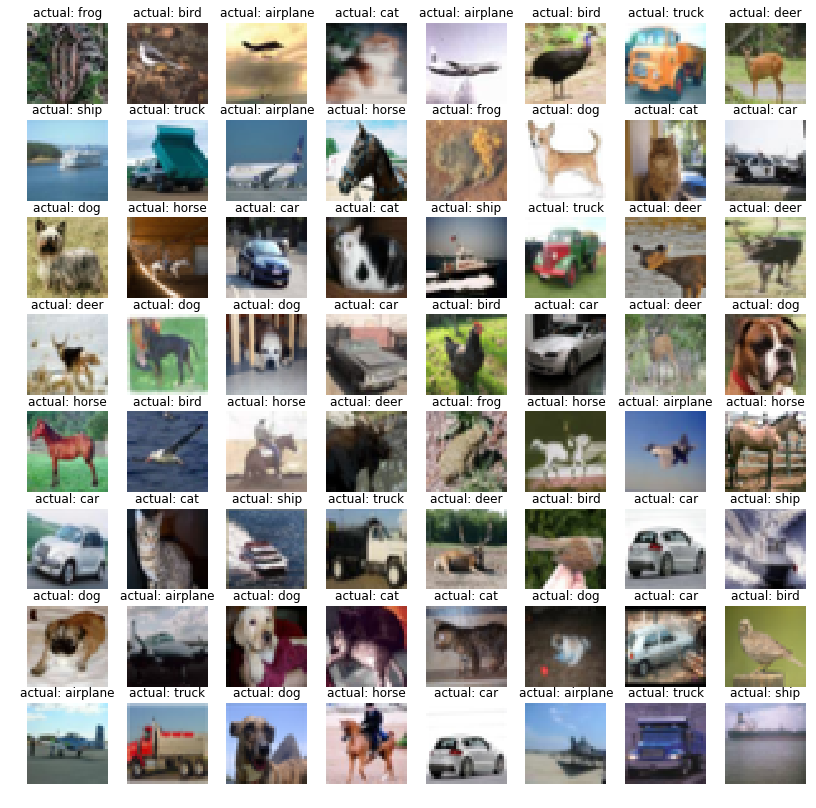

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np

def draw_subplot(position, image, title):
    plt.subplot(*position)
    plt.imshow(image.reshape(32, 32, 3))
    plt.axis('off')
    plt.title(title)
    
def batch_draw(batch_size):
    N = len(train_x)
    index_1dArray = np.arange(N) 
    batch_indexes = np.random.choice(index_1dArray, batch_size)
    images, classIds = train_x[batch_indexes], train_y[batch_indexes]
    image_number = images.shape[0]
    row_number = math.ceil(image_number ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number+6, column_number+6))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < image_number:
                position = (row_number, column_number, index+1)
                image = images[index]
                classId = classIds[index]
                label = label_dict[classId]
                title = 'actual: %s' %label
                draw_subplot(position, image, title)

batch_draw(64)

## 2.搭建神经网络

In [4]:
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.bn_1 = nn.BatchNorm2d(3)
        self.conv_1 = nn.Conv2d(3, 30, (5,5), padding=1) # N * 32 * 32 * 30
        self.maxpool_1 = nn.MaxPool2d(2, 2, padding=1) # N * 16 * 16 * 30
        self.bn_2 = nn.BatchNorm2d(30)
        self.conv_2 = nn.Conv2d(30, 64, (5,5), padding=1) # N * 16 * 16 * 64
        self.maxpool_2 = nn.MaxPool2d(2, 2, padding=1) # N * 8 * 8 * 64
        self.flatten = nn.Flatten()
        self.bn_3 = nn.BatchNorm1d(8 * 8 * 64)
        self.linear_1 = nn.Linear(8 * 8 * 64, 128)
        self.bn_4 = nn.BatchNorm1d(128)
        self.linear_2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # 第1层卷积
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.conv_1(x)
        x = self.maxpool_1(x)
        # 第2层卷积
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        # 2维矩阵展平为1维矩阵
        x = self.flatten(x)
        # 第1层全连接
        x = self.bn_3(x)
        x = self.relu(x)
        x = self.linear_1(x)
        # 第2层全连接
        x = self.bn_4(x)
        x = self.relu(x)
        y = self.linear_2(x)
        return y
    
net = Net()    

## 3.定义损失函数

In [5]:
loss_function = nn.CrossEntropyLoss()

## 4.在训练集上训练网络

In [6]:
import sys
# 实时更新进度条
def print_flush(print_string):
    print(print_string, end='\r')
    sys.stdout.flush()

In [14]:
import random

device = torch.device('cuda')
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
steps = 5000
batch_size = 500
N = len(train_x)
index_1dArray = np.arange(N)
tensor_y = torch.from_numpy(train_y).long()
for i in range(steps+1):
    batch_indexes = np.random.choice(index_1dArray, batch_size)
    # 图像数据处理、从内存到显存
    batch_x = train_x[batch_indexes]
    if random.choice([0,1]):
        batch_x = batch_x[:, :, ::-1, :].copy()
    input_x = torch.from_numpy(batch_x)
    input_x = input_x.to(device)
    input_x = input_x.permute(0, 3, 1, 2).float()
    # 前向传播
    predicted_Y = net(input_x) # predicted_Y.shape: N * 10
    # 计算损失值
    batch_y = tensor_y[batch_indexes]
    input_y = batch_y.to(device) # input_y.shape: N
    loss = loss_function(predicted_Y, input_y)
    loss_value = loss.item()
    # 计算准确率
    predicted_y = predicted_Y.argmax(axis=1)
    accuracy = (predicted_y==input_y).float().mean()
    accuracy_value = accuracy.item()
    # 每隔20步，打印训练记录
    if i % 20 == 0:
        print_flush('step:%d loss_value:%.6f accuracy_value:%.4f' %(
            i, loss_value, accuracy_value))
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 5.模型测试

#### 5.1 加载测试集

In [15]:
# 加载数据集cifar10里面的测试集
def load_test_dataset(dirPath='../resources/CIFAR10_data'):
    fileName = 'test_batch'
    filePath = os.path.join(dirPath, fileName)
    test_x, test_y = load_batch(filePath)
    print('test_x矩阵转置前：', test_x.shape)
    test_x = test_x.transpose(0, 2, 3, 1)
    print('test_x矩阵转置后：', test_x.shape)
    return test_x, test_y

dirPath = '../resources/CIFAR10_data'
test_x, test_y = load_test_dataset(dirPath) 

test_x矩阵转置前： (10000, 3, 32, 32)
test_x矩阵转置后： (10000, 32, 32, 3)


#### 5.2 模型评估

##### 5.2.1 在训练集上准确率很高

In [16]:
predicted_y = np.zeros((len(train_y),))
batch_size = 500
for i in range(0, len(train_x), batch_size):
    start_index = i
    end_index = i + batch_size
    batch_x = train_x[start_index: end_index]
    input_x = torch.from_numpy(batch_x)
    input_x = input_x.to(device)
    input_x = input_x.permute(0, 3, 1, 2).float() 
    predicted_Y = net(input_x)
    predicted_y[start_index:end_index] = predicted_Y.argmax(axis=1).cpu().numpy()
accuracy = (train_y==predicted_y).astype('float').mean()
print(accuracy)

0.98402


##### 5.2.2 在测试集上准确率较低，说明模型提取特征能力弱

In [17]:
predicted_y = np.zeros((len(test_y),))
for i in range(0, len(test_x), batch_size):
    start_index = i
    end_index = i + batch_size
    batch_x = test_x[start_index: end_index]
    input_x = torch.from_numpy(batch_x)
    input_x = input_x.to(device)
    input_x = input_x.permute(0, 3, 1, 2).float() 
    predicted_Y = net(input_x)
    predicted_y[start_index:end_index] = predicted_Y.argmax(axis=1).cpu().numpy()
accuracy = (test_y==predicted_y).astype('float').mean()
print(accuracy)

0.8113


## 6.ResNet

#### 6.1搭建神经网络

In [12]:
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, bn=True):
        super(BasicConv, self).__init__()
        padding = (kernel_size-1) // 2
        self.bn = nn.BatchNorm2d(in_channels) if bn else None
        self.relu = nn.ReLU() if relu else None
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        if self.bn:
            x = self.bn(x)
        if self.relu:
            x = self.relu(x)
        x = self.conv(x)
        return x

In [13]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv0_1 = BasicConv(3, 16, kernel_size=1, relu=False)
        self.conv0_2 = BasicConv(16, 64, kernel_size=1, relu=False, bn=False)
        
        self.conv1_1 = BasicConv(16, 16, kernel_size=1)
        self.conv1_2 = BasicConv(16, 16, kernel_size=3)
        self.conv1_3 = BasicConv(16, 64, kernel_size=1)
        
        self.conv2_1 = BasicConv(64, 16, kernel_size=1)
        self.conv2_2 = BasicConv(16, 16, kernel_size=3)
        self.conv2_3 = BasicConv(16, 64, kernel_size=1)
        self.conv2_4 = BasicConv(64, 128, kernel_size=1, stride=2, relu=False, bn=False)
        
        self.conv3_1 = BasicConv(64, 64, kernel_size=1, stride=2)
        self.conv3_2 = BasicConv(64, 64, kernel_size=3)
        self.conv3_3 = BasicConv(64, 128, kernel_size=1)
        
        self.conv4_1 = BasicConv(128, 64, kernel_size=1)
        self.conv4_2 = BasicConv(64, 64, kernel_size=3)
        self.conv4_3 = BasicConv(64, 128, kernel_size=1)
        self.conv4_4 = BasicConv(128, 256, kernel_size=1, stride=2, relu=False, bn=False)
        
        self.conv5_1 = BasicConv(128, 128, kernel_size=1, stride=2)
        self.conv5_2 = BasicConv(128, 128, kernel_size=3)
        self.conv5_3 = BasicConv(128, 256, kernel_size=1)
        
        self.conv6_1 = BasicConv(256, 128, kernel_size=1)
        self.conv6_2 = BasicConv(128, 128, kernel_size=3)
        self.conv6_3 = BasicConv(128, 256, kernel_size=1)
        
        self.bn_1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
        self.avgPool = nn.AvgPool2d(8, stride=8)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.conv0_1(x)
        x_0 = self.conv0_2(x)
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv1_3(x)
        x = x_0 + x
        x_1 = x
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        x = x_1 + x
        x_2 = self.conv2_4(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = x_2 + x
        x_3 = x
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = x_3 + x
        x_4 = self.conv4_4(x)
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = x_4 + x
        x_5 = x
        x = self.conv6_1(x)
        x = self.conv6_2(x)
        x = self.conv6_3(x)
        x = x_5 + x
        
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
    
net = ResNet()    

In [31]:
from torchsummary import summary 
summary(net.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,